# Asynchronous Q-Learning

---

今回はこの[論文](https://arxiv.org/abs/2006.03041)に書かれているAsynchronous Q-Learningについてコードを書きながら解説していきます．


Asynchronous Q-Learning はオンライン学習の一種のアルゴリズムです．

モデルフリーであり，オフポリシーのアルゴリズムです．

簡単な説明としては，ある方策$\pi_b$があり，その方策によって収集された履歴$\tau=s_0,a_0,s_1,....,$を使って，行動価値関数$Q$を求めていくというアルゴリズムです，

モデルベースと違い，遷移確率関数を予測しないで，履歴から，暗に遷移確率関数を使わないので，実装は楽になります．



---

行動価値関数$Q$の更新式を次に示します．

$$
\begin{aligned}
Q_t\left(s_{t-1}, a_{t-1}\right) & =\left(1-\eta_t\right) Q_{t-1}\left(s_{t-1}, a_{t-1}\right)+\eta_t \mathcal{T}_t\left(Q_{t-1}\right)\left(s_{t-1}, a_{t-1}\right) \\
Q_t(s, a) & =Q_{t-1}(s, a), \quad \forall(s, a) \neq\left(s_{t-1}, a_{t-1}\right)
\end{aligned}
$$

ベルマン作用素の定義は
$$
\mathcal{T}_t(Q)\left(s_{t-1}, a_{t-1}\right):=r\left(s_{t-1}, a_{t-1}\right)+\gamma \max _{a^{\prime} \in \mathcal{A}} Q\left(s_t, a^{\prime}\right) .
$$

になります．

ここで，私がこのアルゴリズムを勉強している時に，疑問に思ったのは，モデルベースでは，遷移確率関数を使って，HoeffdingやBernsteinの不等式などを使って，サンプル効率を求めていたのですが，モデルフリーでは遷移確率を予測しないで，学習を進めているので，どのようにサンプル効率を求めるのか疑問になりますね．

---

今回は細かいサンプル効率の説明は省きますが，サンプル効率を導出する上で，大事になってくる概念をいかに説明します．



$\mu_{pi_b}$を$\pi_b$の定常分布とし，$\mu_{\min }:=\min _{(s, a) \in \mathcal{S} \times \mathcal{A}} \mu_{\pi_b}(s, a)$.と，新しいものを定義します．

$\mu_{min}$は分布の一様さがわかりますね，この値が小さいのならば，全ての状態行動対を探索するにはサンプルが多く必要となってきます．

次に$t_{mix}$という概念は$t_{\text {mix }}:=\min \left\{t \mid \max _{\left(s_0, a_0\right) \in \mathcal{S} \times \mathcal{A}} d_{\text {TV }}\left(P^t\left(\cdot \mid s_0, a_0\right), \mu_{\pi_b}\right) \leq \frac{1}{4}\right\}$,となり，これはある初期状態，行動から始め，どのくらいの時間で，最初の状態から相関を失うかの時間を表しています．

つまり，非定常分布である$P^t$が定常分布$\mu_{\pi_b}$に近くなるかです．

最後に，$t_{cover}$は$t_{\text {cover }}:=\min \left\{t \mid \min _{\left(s_0, a_0\right) \in \mathcal{S} \times \mathcal{A}} \mathbb{P}\left(\mathcal{B}_t \mid s_0, a_0\right) \geq \frac{1}{2}\right\}$は全ての状態行動対に訪れた時の時間を意味しています．



上の概念を使い，サンプル効率を出すことができます．

簡単に説明すると，最初の方に示した更新則を行列形式に書き直し，$Q_t - Q^*$の無限大ノルムを解いていくようなことをします．

詳しい解説は論文を参照してください．

---

ここからコードの解説をしてきます．

まず，アルゴリズムは次のようになっていきます．

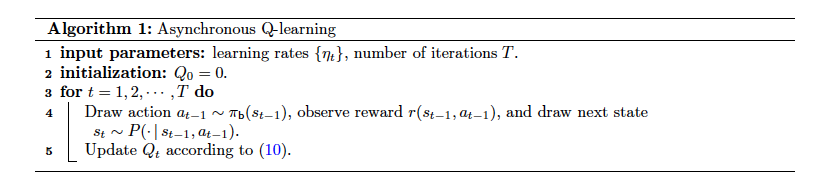


In [45]:
# 環境の構築

import numpy as np
import jax.numpy as jnp
from jax.random import PRNGKey
import jax
from typing import NamedTuple,Optional

key = PRNGKey(0)
S = 5 #状態空間
A = 3 #行動空間
S_set = jnp.arange(S)
A_set = jnp.arange(A)
gamma = 0.9 #割引率

#報酬と遷移確率の行列を作る．
key,_ = jax.random.split(key)
rew = jax.random.uniform(key,shape=(S,A))

key,_ = jax.random.split(key)
P = jax.random.uniform(key,shape=(S*A,S))
P = P / P.sum(axis=-1,keepdims=True)
P = P.reshape(S,A,S)
np.testing.assert_allclose(P.sum(axis=-1),1,atol=1e-6)

#MDPの作成
class MDP(NamedTuple):
    S_set: jnp.ndarray
    A_set: jnp.ndarray
    rew: jnp.ndarray
    P: jnp.ndarray
    gamma: float
    H:int #ホライゾン
    optimal_Q:Optional[jnp.ndarray] = None

    @property
    def S(self):
        return len(self.S_set)
    
    @property
    def A(self):
        return len(self.A_set)
    

H = int(1/(1-gamma))
mdp = MDP(S_set,A_set,rew,P,gamma,H)


**真のMDPを使った最適な行動価値関数と履歴から求めた行動価値関数を比較するのがゴールなので,最適な行動価値関数を求めるコードを書きます．**

In [46]:
from functools import partial
import chex

#最適な行動価値関数の計算
@partial(jax.jit,static_argnames=('S','A'))
def _compute_optimal_Q(mdp:MDP,S:int,A:int):
    Q = jnp.zeros((S,A))

    def backup(Q:chex.Array):
        v = jnp.max(Q,axis=-1)
        return mdp.rew + mdp.gamma * mdp.P @ v
    body_fn = lambda i,Q:backup(Q)

    return jax.lax.fori_loop(0,mdp.H+100,body_fn,Q)

compute_optimal_Q = lambda mdp: _compute_optimal_Q(mdp,mdp.S,mdp.A)
optimal_Q = compute_optimal_Q(mdp)
mdp = mdp._replace(optimal_Q=optimal_Q)


In [51]:
from tqdm import tqdm
T = H+1000 #試行回数

#履歴を集める作業
asy_Q_list = []
learning_rates = [0.1,0.3,0.5,0.7,0.9]
for learning_rate in learning_rates:
    s = 0
    asy_Q = jnp.zeros((S,A))
    for i in tqdm(range(T)):
        key,_ = jax.random.split(key)
        #pi_bはランダムな方策とします
        action = jax.random.choice(key,mdp.A)
        reward = mdp.rew[s, action]
        s_next = jax.random.choice(key,mdp.S,p=mdp.P[s,action])
        asy_Q = asy_Q.at[s,action].set((1-learning_rate) *asy_Q[s,action] + learning_rate * (reward + mdp.gamma * jnp.max(asy_Q[s_next])))
        
        s = s_next
    asy_Q_list.append(asy_Q)
    

100%|██████████| 1010/1010 [00:08<00:00, 112.83it/s]


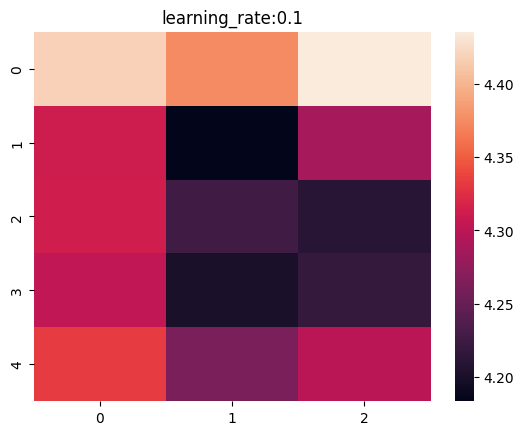

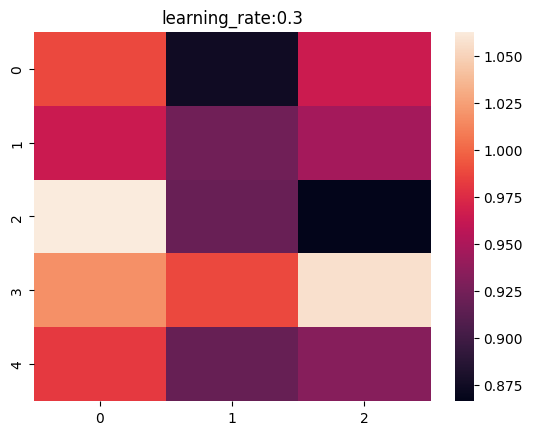

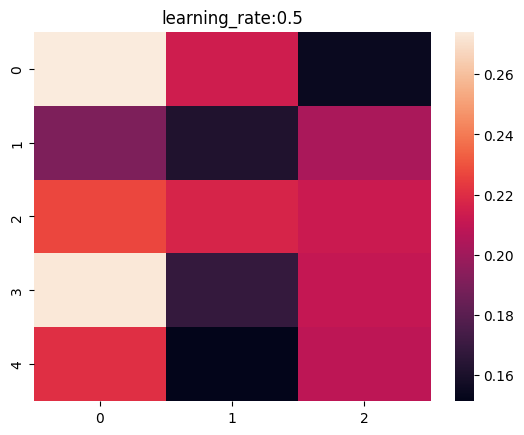

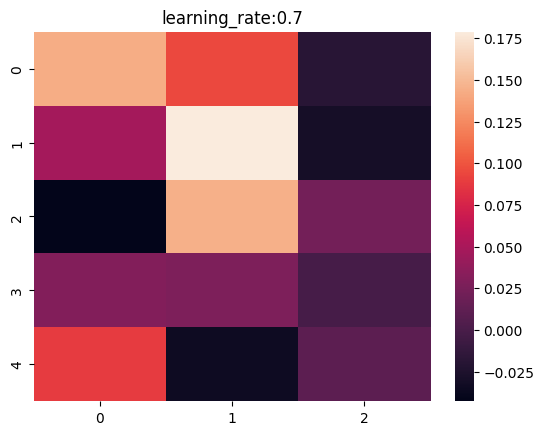

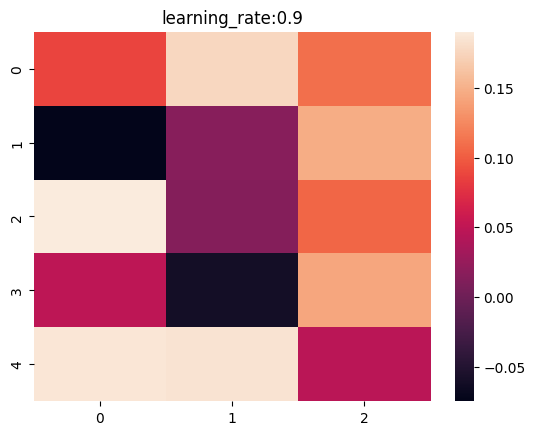

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns
for i, data in enumerate(asy_Q_list):
    sns.heatmap(optimal_Q -asy_Q_list[i])
    plt.title(f"learning_rate:{learning_rates[i]}")
    plt.show()


学習率が大きいほど，最適な行動価値関数に近づいていることがわかります．